In [1]:
from collections import defaultdict
import os

import keras
from keras.models import Model
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

import core
from core.cam import overlay_gradcam
from core.fine_model import FineModel
import cr_interface as cri
from cr_interface import CrCollection

from sklearn.manifold import TSNE

Using TensorFlow backend.


In [2]:
CACHE_DIR = os.path.join(os.getcwd(), 'cache')
os.makedirs(CACHE_DIR, exist_ok=True)

In [158]:
def get_partial_model(model: keras.models.Model):
    """Get model that outputs pooled features
    """
    def _get_penultimate_layer_index(model):
        for index, layer in enumerate(model.layers):
            if isinstance(layer, keras.layers.pooling.GlobalAveragePooling2D):
                return index
        raise AssertionError("model should have a GlobalAveragePooling2D layer")
    layer_index = _get_penultimate_layer_index(model)
    return Model(inputs=model.input, outputs=model.layers[layer_index].output)

## Init MobileNet w/ Custom Classifier

In [133]:
base_model = keras.applications.mobilenet.MobileNet(include_top=False, pooling='avg', weights='imagenet', input_shape=(224, 224, 3))

In [142]:
from keras.layers import Flatten, Dense, Dropout
outputs = base_model.output
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)
model = keras.models.Model(inputs=base_model.input, outputs=outputs)

In [144]:
# Freeze layers
for index in range(gap_layer + 1):
    model.layers[index].trainable = False
    if isinstance(layer, keras.layers.pooling.GlobalAveragePooling2D):
        break

In [145]:
optimizer = keras.optimizers.Adam()

In [146]:
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

## Define data

In [147]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet.preprocess_input)
aug_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=keras.applications.mobilenet.preprocess_input)

In [204]:
input_shape = model.layers[0].input_shape[1:3]
train_gen = aug_datagen.flow_from_directory('cd_train', target_size=input_shape, shuffle=True, batch_size=16)
test_gen = datagen.flow_from_directory('cd_test', target_size=input_shape, shuffle=False, batch_size=16)

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


## Train/Evaluate

In [149]:
model.fit_generator(train_gen, validation_data=test_gen, validation_steps=len(test_gen), steps_per_epoch=len(train_gen), epochs=10)

Epoch 1/10
50/50 [==============================] - 45s 896ms/step - loss: 0.7158 - acc: 0.6900 - val_loss: 0.3748 - val_acc: 0.8400
Epoch 2/10
50/50 [==============================] - 43s 869ms/step - loss: 0.4050 - acc: 0.8263 - val_loss: 0.1279 - val_acc: 0.9450
Epoch 3/10
50/50 [==============================] - 43s 868ms/step - loss: 0.2919 - acc: 0.8925 - val_loss: 0.1403 - val_acc: 0.9400
Epoch 4/10
50/50 [==============================] - 43s 870ms/step - loss: 0.2666 - acc: 0.8812 - val_loss: 0.1076 - val_acc: 0.9450
Epoch 5/10
50/50 [==============================] - 48s 963ms/step - loss: 0.2483 - acc: 0.8988 - val_loss: 0.0957 - val_acc: 0.9450
Epoch 6/10
50/50 [==============================] - 56s 1s/step - loss: 0.1973 - acc: 0.9137 - val_loss: 0.0977 - val_acc: 0.9400
Epoch 7/10
50/50 [==============================] - 49s 973ms/step - loss: 0.2232 - acc: 0.9150 - val_loss: 0.0910 - val_acc: 0.9550
Epoch 8/10
50/50 [==============================] - 60s 1s/step - loss: 

In [162]:
model.evaluate_generator(test_gen, steps=len(test_gen), verbose=1)

13/13 [==============================] - 11s 809ms/step


[0.1719984143367037, 0.92]

## Manual Prediction

In [156]:
image = keras.preprocessing.image.load_img('image.jpg', target_size=(224, 224))
image = keras.preprocessing.image.img_to_array(image)
image = image.reshape((1,) + image.shape)
image = keras.applications.mobilenet.preprocess_input(image)

In [157]:
result = model.predict(image)
result

array([[0.2665939, 0.7334061]], dtype=float32)

## Extract Intermediate (Pooled) Features

In [205]:
partial = get_partial_model(model)
test_gen.reset()
features = partial.predict_generator(test_gen, steps=len(test_gen))

In [206]:
features.shape

(200, 1024)

## Cache Outputs

In [207]:
output_cache_path = os.path.join(CACHE_DIR, 'pooled_output_cd.npy')

In [208]:
np.save(output_cache_path, features)

In [209]:
features = np.load(output_cache_path)

## Validate Extracted Features

In [219]:
input_step = keras.layers.Input(model.layers[88].input_shape[1:])
step = input_step
for layer in model.layers[88:]:
    step = layer(step)
classifier = Model(inputs=input_step, outputs=step)

In [220]:
classes = classifier.predict(features)

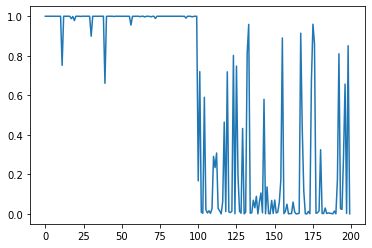

In [224]:
plt.plot(classes[:,0])

## Extract tSNE

In [213]:
raw = TSNE(n_components=2, random_state=0).fit_transform(features)

In [214]:
raw.shape

(200, 2)

## Plot tSNE

In [225]:
LABEL_INDICES = {
    'oap': 0,
    'obs': 1,
    'in': 2,
}

def get_tsne_figure(raw):
    embeddings = pd.DataFrame(raw)
    embeddings.columns = ['x', 'y']
    embeddings['label_index'] = [0] * 100 + [1] * 100
    
    fig = mpl.figure.Figure(figsize=(8, 6), constrained_layout=True)
    ax = fig.subplots()
    scatter = ax.scatter(embeddings.x, embeddings.y, c=embeddings.label_index, cmap='viridis', alpha=0.8)
    legend1 = ax.legend(scatter.legend_elements()[0],
                        ['CAT', 'DOG'],
                        title="Ground Truth")
    fig_title = 'tSNE Analysis of Cat/Dog Features'
    fig.suptitle(fig_title, fontweight='bold', fontsize=14)
    
    return fig

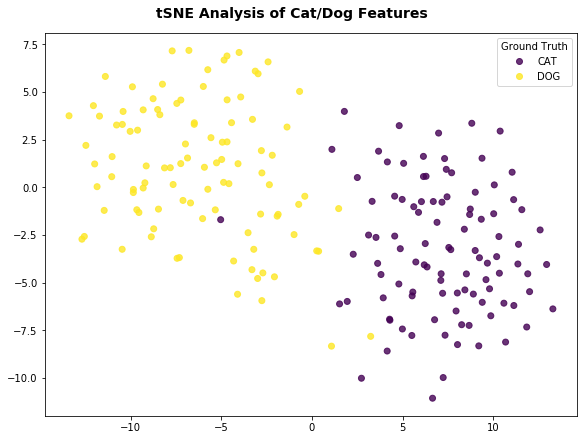

In [226]:
fig = get_tsne_figure(raw)
fig

In [228]:
fig.savefig('tSNE_cat_dog.png', dpi=320, bbox_inches='tight')